In [33]:
%matplotlib inline 

import numpy as np
import os
from matplotlib import pyplot as plt

#loading the images
import skimage.io as io



In [272]:
import random
from skimage.transform import resize

fns = os.listdir('MNIST/3')

imgs = []

for i in [3, 8]:
    for fn in os.listdir('MNIST/' + str(i)):
        img = io.imread('MNIST/%d/%s' % (i, fn), dtype=np.float64)
        img = resize(img, (29, 29))
        img = img / 255
        imgs.append((img, 1 if i == 8 else 0))

random.shuffle(imgs)

inputs = np.zeros((len(imgs), 29, 29))
outputs = np.zeros((len(imgs)))

for i, (img, cls) in enumerate(imgs):
    inputs[i] = img
    outputs[i] = cls
    
inputs = inputs.reshape(len(inputs), 29, 29, 1)


/home/rafael/Apps/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [408]:
import math
from scipy.special import expit
from scipy.signal import correlate

#derro/df1[i] = sum in j: derro/dint[j] * dint[j]*df1[i]
def grad_filter1(mat1, grad_mat2):
    a = np.zeros(grad_mat2.shape)
    
    for filter_i in np.ndindex(grad_mat2.shape):
        a[filter_i] = 0
        
        for mat2_i in np.ndindex(grad_mat2.shape):
            a[filter_i] += grad_mat2[mat2_i] * mat1[filter_i[0] + mat2_i[0], filter_i[1] + mat2_i[1]]
            
    return a

def grad_mat2(factor, filter2):
    return factor * filter2

def grad_filter2(factor, mat2):
    return factor * mat2
    

# sigma((mat conv filter1) conv filter2) 
def train_step(mat1, filter1, filter2, coeff, correct, lr):
    mat2 = correlate(mat1, filter1, mode='valid')
    mat2[mat2 > 1] = 1
    mat2[mat2 < 0] = 0
    v = correlate(mat2, filter2, mode='valid')[0][0]
    v2 = coeff[0] * v
    final = expit(v2)
    error = 0.5 * (final - correct)**2
    
    #derro/dv2 = derro/dfinal * dfinal/dv2
    derro_dv2 = (final - correct) * final * (1 - final)
    
    #derro/dv = derro/dv2 * dv2/dv
    derro_dv = derro_dv2 * coeff[0]
    
#     print('error:', error, 'final:', final, 'correct:', correct, 'factor:', derro_dv2)
    
    gfilter2 = grad_filter2(derro_dv, mat2)
    gmat2 = grad_mat2(derro_dv, filter2)
    gfilter1 = grad_filter1(mat1, gmat2)
    
    #derro/dcoeff = derro/dv2 * dv2/dcoeff = 
    gcoeff = derro_dv2 * v
    
    coeff[0] -= lr * gcoeff
    
    for i in np.ndindex(filter1.shape):
        filter1 -= lr * gfilter1[i]
        filter2 -= lr * gfilter2[i]

    return 1 if final >= 0.5 else 0

In [418]:
from IPython.display import clear_output

factor = 0.1
filter1 = (np.random.rand(15,15) - 0.5) * factor
filter2 = (np.random.rand(15,15) - 0.5) * factor
coeff = np.random.rand(1) - 0.5

# img, cls = imgs[8]

# print(cls)

# for i in range(30):
#     train_step(img, filter1, filter2, cls, 0.01)

for i in range(10):
    right = 0
    for i, (img, cls) in enumerate(imgs[:500]):
        res = train_step(img, filter1, filter2, coeff, cls, 0.1)
        if res == cls: right += 1
        clear_output(wait=True)
        print(i+1, '=> %.2f' % (100 * right / (i+1)))
            

150 => 47.33


KeyboardInterrupt: 

In [434]:
import keras

from keras.initializers import RandomUniform

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

model = Sequential()

firstFilter = Conv2D(1, kernel_size=(15, 15), kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05), activation=None, input_shape=(29, 29, 1), use_bias=False)

model.add(firstFilter)

secondFilter = Conv2D(1, (15, 15), kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05), activation=None, use_bias=False)
model.add(secondFilter)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05), use_bias=False))

# print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

filter1 = model.layers[0].get_weights()[0].reshape(15,15)
copy_filter1 = np.copy(filter1)
filter2 = model.layers[1].get_weights()[0].reshape(15,15)
copy_filter2 = np.copy(filter2)
coeff = model.layers[3].get_weights()[0][0]
copy_coeff = np.copy(coeff) 

id = 3
model.fit(inputs[id:id+1], outputs[id:id+1],
          epochs=1,
          verbose=1,  
          batch_size=1,
          shuffle=False)

filter1 = model.layers[0].get_weights()[0].reshape(15,15)
print(filter1)
print("******************************************************************")
#print(inputs[id:id+1][0].shape)
train_step(inputs[id:id+1][0].reshape(29,29), copy_filter1, copy_filter2, copy_coeff, outputs[id:id+1][0], 0.01)
print(copy_filter1)

print(filter1.mean(), copy_filter1.mean())

# train_size = int(len(inputs) * 0.9)
# train_in = inputs[:train_size]
# train_out = outputs[:train_size]
# test_in = inputs[train_size:]
# test_out = outputs[train_size:]

# #draw_filters(model)

# model.fit(inputs, outputs,
#           epochs=10,
#           verbose=1, 
#           validation_data=(test_in, test_out), 
#           batch_size=1)

# draw_filters(model)

Epoch 1/1
1/1 [==============================] - 1s 675ms/step - loss: 0.6947 - acc: 0.0000e+00
[[ 0.01022587 -0.04718844 -0.03766644 -0.03659194  0.03495463  0.03336221
   0.01496935  0.00398887  0.04511381  0.04006607 -0.03860768 -0.04884991
  -0.04621619  0.02678109  0.00301831]
 [-0.00954448  0.03292819 -0.01201141  0.01745101  0.03272355 -0.03353087
  -0.00453259  0.00892371 -0.04443229 -0.04675454 -0.04908092  0.03509136
  -0.02048135  0.03501597  0.02063388]
 [-0.03466879  0.04357678 -0.03390976  0.04054341  0.0305996   0.03966093
   0.02480429  0.01490514 -0.00063514 -0.01494047  0.01013571  0.01459143
   0.00041085 -0.02198202  0.02615704]
 [-0.00609105  0.02589246  0.01957709 -0.01442436  0.00733278  0.04661325
  -0.04957039  0.03842186  0.00016497 -0.04368169 -0.02925579  0.02853749
   0.0397974   0.00867453 -0.03183948]
 [-0.01656682  0.03165548  0.01268001  0.04564029 -0.03103963 -0.04451135
   0.03644418 -0.02606441 -0.04047634 -0.02868516 -0.02473688  0.0273874
  -0.0125

In [391]:
filter1 = model.layers[0].get_weights()[0].reshape(15,15)
filter2 = model.layers[1].get_weights()[0].reshape(15,15)

coeff = model.layers[3].get_weights()[0][0]

count = 0
for i, (img, cls) in enumerate(imgs):
    result1 = model.predict(img.reshape(1, 29,29, 1))[0][0]
    inter = correlate(img, filter1, mode='valid') 
    v = correlate(inter, filter2, mode='valid')[0][0] 
    result2 = expit(coeff * v)
    
    r1 = 1 if result1 > 0.5 else 0
    r2 = 1 if result2 > 0.5 else 0
    
    if r1 != r2:
        print(r1, r2)
        count += 1

print(count)

# print(model.layers[3])

0


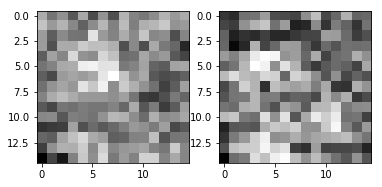

[array([[1.7791573]], dtype=float32)]


In [372]:
def draw_filters(model):    
    plt.subplot(121)
    weights = model.layers[0].get_weights()[0]
    weights = weights.reshape(15,15)
    plt.imshow(weights, cmap="gray")
    
    plt.subplot(122)
    weights = model.layers[1].get_weights()[0]
    weights = weights.reshape(15,15)
    plt.imshow(weights, cmap="gray")
    
    plt.show()
    
    weights = model.layers[3].get_weights()
    print(weights)
    
draw_filters(model)


In [ ]:
import scipy.ndimage.filters

from scipy.special import expit

def relu(mat):
    mat[mat < 0] = 0

id = 16

img = inputs[id].reshape(29,29)
plt.imshow(img, cmap="gray")
plt.show()

res = model.predict(inputs[id:id+1], verbose=1)[0][0]
print("Predict:", res)

img = inputs[id:id+1].reshape(29,29)
print(img.shape)

filter1 = model.layers[0].get_weights()[0].reshape(15,15)
bias1 = model.layers[0].get_weights()[1]
filter2 = model.layers[1].get_weights()[0].reshape(15,15)
bias2 = model.layers[1].get_weights()[1]

res = scipy.ndimage.filters.convolve(img, filter1)[7:22, 7:22]
relu(res)
res = scipy.ndimage.filters.convolve(res, filter2)[7:8, 7:8]
relu(res)
res = res[0,0]
print("Before last layer:", res)

weights = model.layers[3].get_weights()
coeff = weights[0][0,0]
bias = weights[1][0]

res = coeff * res + bias
print("Before sigma:", res)
res = expit(res)
print("After sigma:", res)

In [ ]:
from keras.models import Model

id=25
imgKeras = inputs[id:id+1]
#imgKeras = np.ones((1,29,29,1))
#print(imgKeras.shape)
imgConv = imgKeras.reshape(29,29)

res = model.predict(imgKeras)
print(res[0][0])

plt.subplot(121)
plt.imshow(imgConv, cmap="gray")

intermediate_layer_model = Model(inputs=firstFilter.input, outputs=firstFilter.output)
intermediate_output = intermediate_layer_model.predict(imgKeras).reshape(15,15)

plt.subplot(122)
plt.imshow(intermediate_output, cmap="gray")
plt.show()

#print(model.layers[0].get_weights())
# filter1 = model.layers[0].get_weights()[0].reshape(15,15)
# res = scipy.ndimage.filters.convolve(imgConv, filter1)[7:22, 7:22]
# relu(res)
# print(res[0])